In [61]:
%matplotlib inline
import GEOparse
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklego.linear_model import LowessRegression
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)


In [62]:
data = pd.read_csv("../Dataset/Abdollahi2019/data.csv", na_values=["#NULL!"])

In [108]:
data.isna().sum().sum()

0

In [65]:
table = data.iloc[:,1:5]

In [66]:
np.mean(table)

miRNA21     2.031042
miRNA638    0.144445
miRNA148    0.473948
miRNA152    0.029582
dtype: float64

In [67]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [68]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

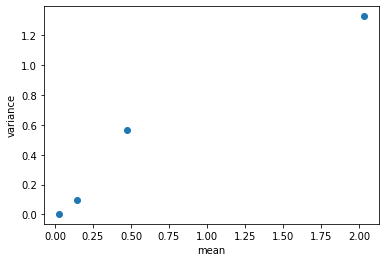

In [69]:
mean_variance_plot(table)

[]

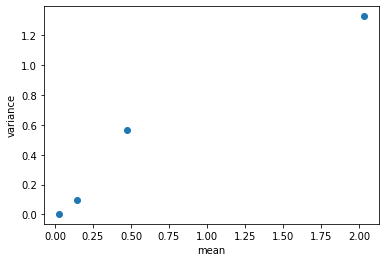

In [70]:
means, variances = get_means_and_variances(table)
plt.scatter(means, variances)
plt.xlabel("mean")
plt.ylabel("variance")
plt.plot()

### Trying log-transformation

In [71]:
log_table = table

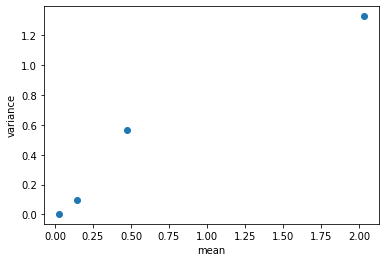

In [72]:
mean_variance_plot(log_table)

In [73]:
norm_log_table = log_table#log_table - np.mean(log_table)

In [74]:
#norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

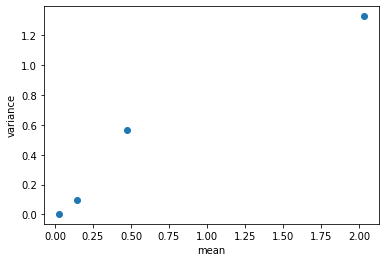

In [75]:
mean_variance_plot(norm_log_table)

### ANOVA

In [76]:
norm_log_table

,miRNA21,miRNA638,miRNA148,miRNA152
0,1.3377,0.011290,0.271030,0.033790
1,1.5951,0.015820,1.008280,0.002319
2,1.2231,0.013401,1.015100,0.181500
3,1.5355,0.018530,1.061010,0.001658
4,1.1760,0.010070,1.029600,0.049645
...,...,...,...,...
81,1.2804,0.000000,0.067030,0.001087
82,1.4254,0.022450,0.070910,0.000322
83,2.2014,0.151200,0.028980,0.011490
84,2.8941,0.000020,0.160300,0.001782


In [77]:
controls = data["group"] == 1

In [78]:
X = np.array(controls).reshape(-1, 1)

In [79]:
linreg = LinearRegression()
linreg.fit(X, norm_log_table)

LinearRegression()

In [80]:
fitted = linreg.predict(X)
explained_variance_score(norm_log_table, fitted, multioutput="variance_weighted")

0.2628281911017919

# PCA

In [81]:
pca = decomposition.PCA(n_components=2)

In [82]:
pca.fit(norm_log_table)

PCA(n_components=2)

In [83]:
components = pca.transform(norm_log_table)

In [84]:
components

array([[-5.84436371e-01, -4.18432035e-01],
       [-5.74094776e-01,  3.61687656e-01],
       [-9.28821852e-01,  2.50960862e-01],
       [-6.47361540e-01,  3.92719739e-01],
       [-9.77441069e-01,  2.48428994e-01],
       [-7.30206045e-01,  3.89948679e-01],
       [-5.48399225e-01,  2.85232377e-01],
       [-4.90326775e-01,  4.35090567e-01],
       [-1.37933159e+00,  3.18358381e+00],
       [-1.12938464e+00,  8.25768301e-02],
       [-9.91256690e-01, -8.31777394e-01],
       [-1.84566027e-01, -5.60911222e-01],
       [-4.02325958e-02, -5.17074831e-01],
       [ 1.34927712e-01, -4.47396189e-01],
       [-8.26543345e-01, -7.84728884e-01],
       [ 1.91814661e-01, -4.16254021e-01],
       [-1.80379414e+00,  2.04125736e+00],
       [-8.26511846e-01, -7.85087383e-01],
       [-1.16322704e+00,  1.18789362e-01],
       [-8.37050447e-01, -7.82829515e-01],
       [-9.12080446e-02, -3.12842908e-01],
       [-6.02733020e-01,  6.90097030e-01],
       [ 1.60606463e-01, -4.52427985e-01],
       [ 3.

In [85]:
sick = 1 - controls

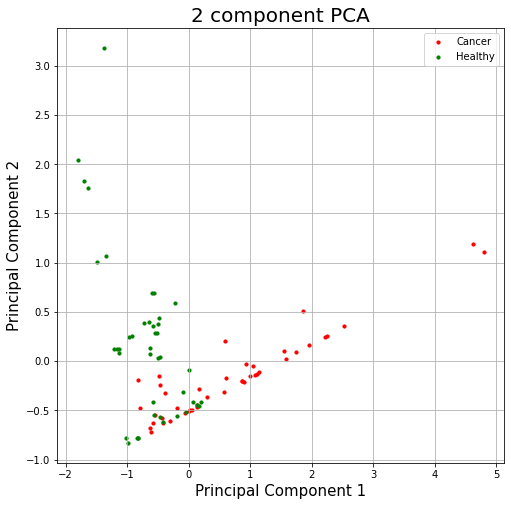

In [86]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

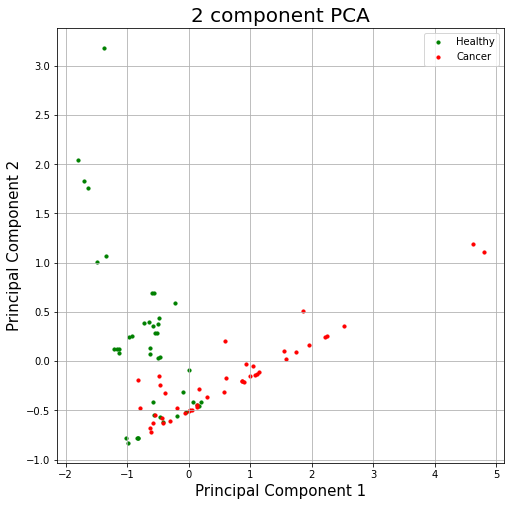

In [87]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy'][::-1]
colors = ['r', 'g']
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.legend(targets)
ax.grid()

### Linear regression adjustments

In [88]:
covars = data.iloc[:,5:8]

In [89]:
covars

,Age,Livingplace,Smoker
0,66,2.000000,1.0
1,61,2.000000,1.0
2,68,1.000000,2.0
3,67,2.000000,1.0
4,66,1.000000,1.0
...,...,...,...
81,67,2.000000,2.0
82,64,2.000000,1.0
83,72,1.532468,1.0
84,71,2.000000,1.0


In [90]:
covars = covars.fillna(covars.mean())

In [91]:
linreg = LinearRegression()
linreg.fit(covars, norm_log_table)

LinearRegression()

In [92]:
adj_norm_log_table = norm_log_table# - linreg.predict(covars)

# PCA

In [93]:
pca = decomposition.PCA(n_components=2)

In [94]:
pca.fit(adj_norm_log_table)

PCA(n_components=2)

In [95]:
components = pca.transform(adj_norm_log_table)

In [96]:
components

array([[-5.84436371e-01, -4.18432035e-01],
       [-5.74094776e-01,  3.61687656e-01],
       [-9.28821852e-01,  2.50960862e-01],
       [-6.47361540e-01,  3.92719739e-01],
       [-9.77441069e-01,  2.48428994e-01],
       [-7.30206045e-01,  3.89948679e-01],
       [-5.48399225e-01,  2.85232377e-01],
       [-4.90326775e-01,  4.35090567e-01],
       [-1.37933159e+00,  3.18358381e+00],
       [-1.12938464e+00,  8.25768301e-02],
       [-9.91256690e-01, -8.31777394e-01],
       [-1.84566027e-01, -5.60911222e-01],
       [-4.02325958e-02, -5.17074831e-01],
       [ 1.34927712e-01, -4.47396189e-01],
       [-8.26543345e-01, -7.84728884e-01],
       [ 1.91814661e-01, -4.16254021e-01],
       [-1.80379414e+00,  2.04125736e+00],
       [-8.26511846e-01, -7.85087383e-01],
       [-1.16322704e+00,  1.18789362e-01],
       [-8.37050447e-01, -7.82829515e-01],
       [-9.12080446e-02, -3.12842908e-01],
       [-6.02733020e-01,  6.90097030e-01],
       [ 1.60606463e-01, -4.52427985e-01],
       [ 3.

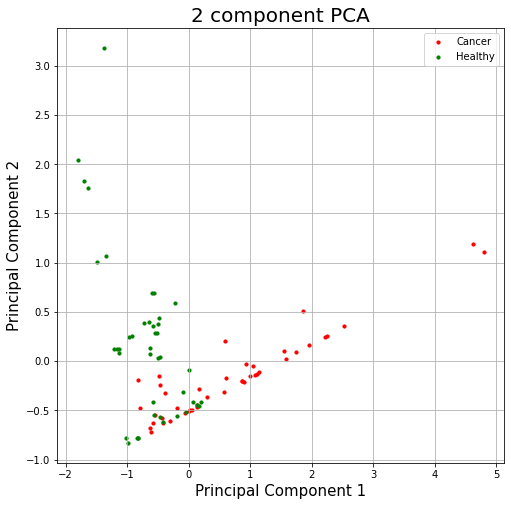

In [97]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### XGBoost

In [98]:
X_train, X_test, y_train, y_test = train_test_split(adj_norm_log_table, controls, test_size=0.33, random_state=42)

In [99]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[15:20:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


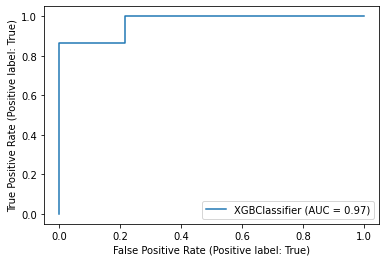

In [100]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [101]:
mirnas = ["hsa-miR-21-5p", "hsa-miR-638", "hsa-miR-148a-3p", "hsa-miR-152-3p"]

In [102]:
from Scripts import converters

In [103]:
sequences = converters.canonical_to_seq(mirnas)

In [104]:
adj_norm_log_table.columns = sequences
adj_norm_log_table *= -1
adj_norm_log_table["cancer"] = sick
adj_norm_log_table.head()

,UAGCUUAUCAGACUGAUGUUGA,AGGGAUCGCGGGCGGGUGGCGGCCU,UCAGUGCACUACAGAACUUUGU,UCAGUGCAUGACAGAACUUGG,cancer
0,-1.3377,-0.011290,-0.27103,-0.033790,0
1,-1.5951,-0.015820,-1.00828,-0.002319,0
2,-1.2231,-0.013401,-1.01510,-0.181500,0
3,-1.5355,-0.018530,-1.06101,-0.001658,0
4,-1.1760,-0.010070,-1.02960,-0.049645,0


In [105]:
#norm_log_table.to_csv("../TransformedData/Asakura2020.csv", index=False)
adj_norm_log_table.to_csv("../TransformedData/Abdollahi2019_raw.csv", index=False)